In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
import pandas as pd

train_df = pd.read_csv('train.csv')
train_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
def filter_columns_by_nunique(df, min_nunique=None, max_nunique=None):
  filtered_columns = []
  for col in df.columns:
    nunique = df[col].nunique()
    include_col = True

    if min_nunique is not None and nunique < min_nunique:
      include_col = False
    if max_nunique is not None and nunique > max_nunique:
      include_col = False

    if include_col:
      filtered_columns.append(col)

  return df[filtered_columns]
def divide_features(df):
  numeric_cols = df.select_dtypes(include=['number']).columns
  categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns

  numeric_df = df[numeric_cols]
  categorical_df = df[categorical_cols]

  return categorical_df, numeric_df

In [ ]:
categorical_df, numeric_df = divide_features(train_df)
categorical_df = filter_columns_by_nunique(categorical_df, 0,2)
categorical_df = categorical_df.drop("Alley", axis = 1)
categorical_df

,Street,Utilities,CentralAir
0,Pave,AllPub,Y
1,Pave,AllPub,Y
2,Pave,AllPub,Y
3,Pave,AllPub,Y
4,Pave,AllPub,Y
...,...,...,...
1455,Pave,AllPub,Y
1456,Pave,AllPub,Y
1457,Pave,AllPub,Y
1458,Pave,AllPub,Y


In [ ]:
# One hot encoding
# Street_Pave: 1 = Pave, 0 = Grvl; CentralAir_Y: 1 = Yes (has central air), 0 = No
categorical_encoded_df = pd.get_dummies(categorical_df, drop_first=True)
categorical_encoded_df = categorical_encoded_df.astype(int)
categorical_encoded_df.apply(pd.Series.value_counts).fillna(0).astype(int)
categorical_encoded_df = categorical_encoded_df.drop(categorical_encoded_df.columns[1], axis=1)
print(categorical_encoded_df.apply(pd.Series.value_counts).fillna(0).astype(int))
categorical_encoded_df

   Street_Pave  CentralAir_Y
1         1454          1365
0            6            95


,Street_Pave,CentralAir_Y
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
1455,1,1
1456,1,1
1457,1,1
1458,1,1


In [ ]:
clean_df = pd.concat([categorical_encoded_df, numeric_df], axis=1)
clean_df = clean_df.fillna(0)
clean_df = clean_df.drop(["Id", "MoSold", "YrSold"], axis = 1)

scaler = StandardScaler()
scaled_df = scaler.fit_transform(clean_df)

pca = PCA(n_components=0.8)
df_pca = pca.fit_transform(scaled_df)

df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])

loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=clean_df.columns
)

loadings['total_contrib'] = loadings.iloc[:, :pca.n_components_].abs().sum(axis=1)
top_vars = loadings.sort_values('total_contrib', ascending=False).head(20)
selected_features = top_vars.index.tolist()
selected_features

['BsmtFinSF2',
 'BsmtHalfBath',
 'EnclosedPorch',
 'PoolArea',
 'LowQualFinSF',
 '3SsnPorch',
 'MiscVal',
 'Street_Pave',
 'OpenPorchSF',
 'LotFrontage',
 'OverallCond',
 'ScreenPorch',
 'KitchenAbvGr',
 'CentralAir_Y',
 'MSSubClass',
 'BsmtFinSF1',
 'YearRemodAdd',
 'WoodDeckSF',
 'HalfBath',
 'GarageYrBlt']

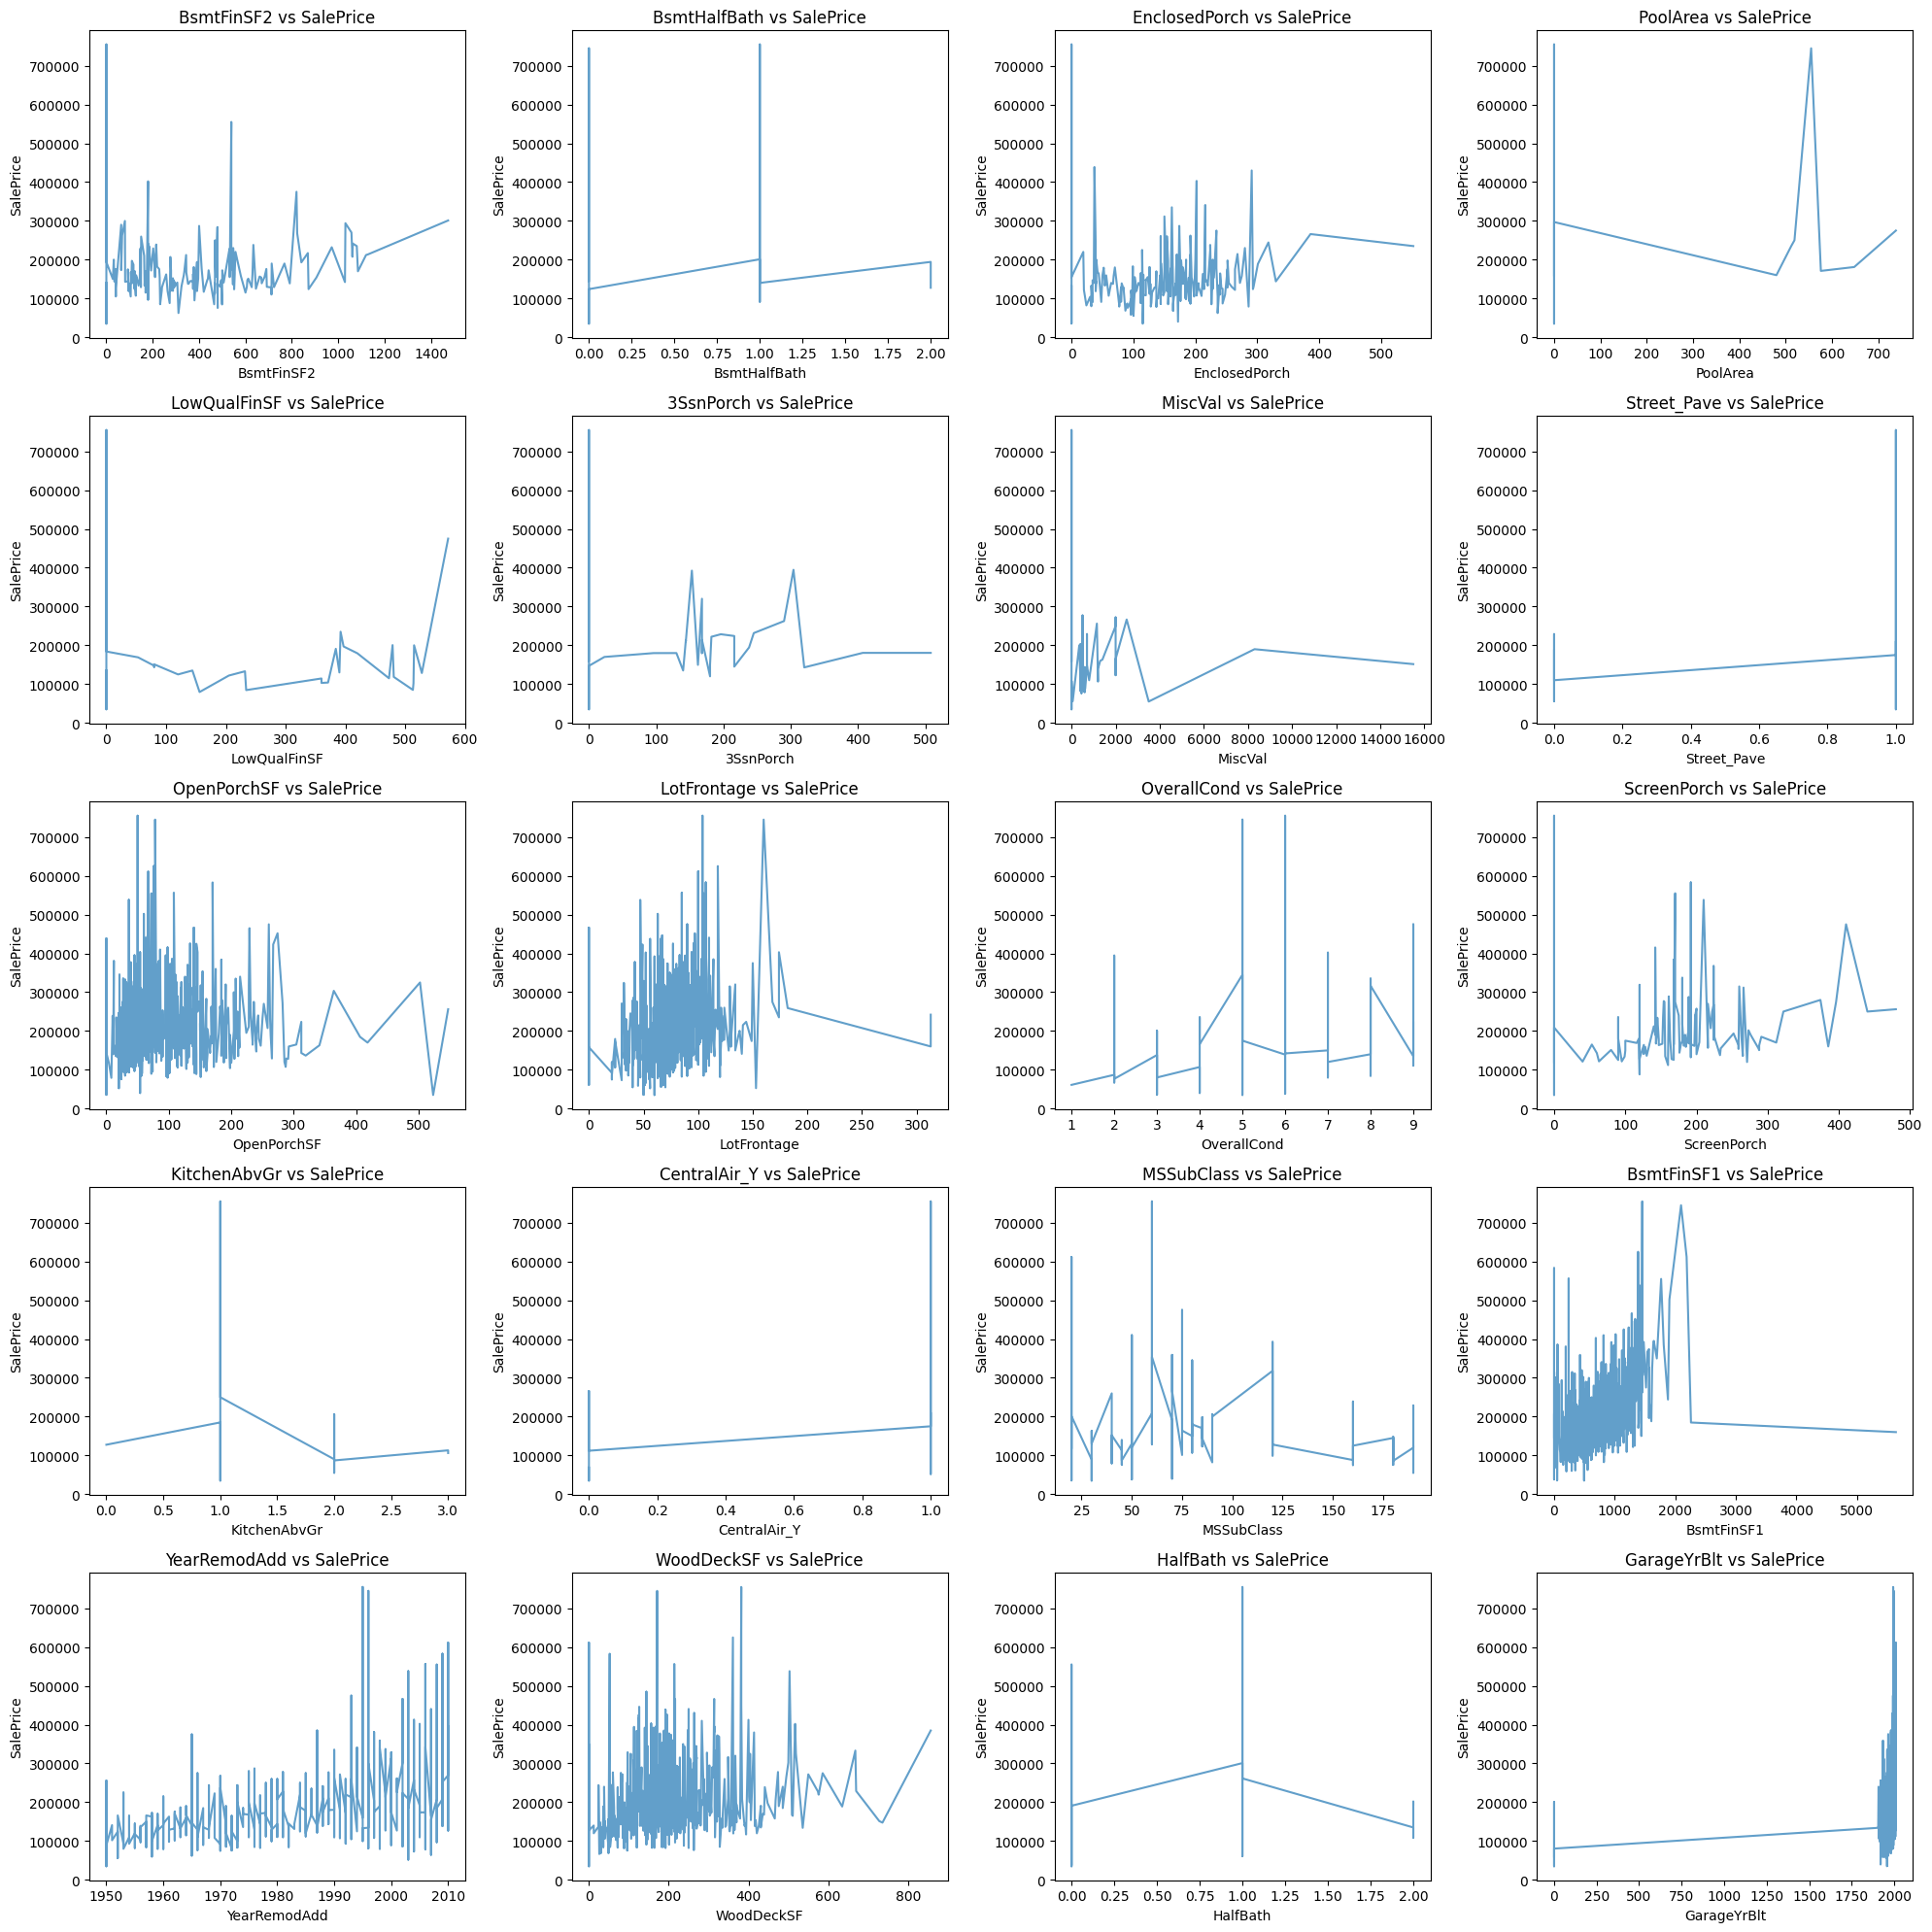

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

variables = ['BsmtFinSF2',
 'BsmtHalfBath',
 'EnclosedPorch',
 'PoolArea',
 'LowQualFinSF',
 '3SsnPorch',
 'MiscVal',
 'Street_Pave',
 'OpenPorchSF',
 'LotFrontage',
 'OverallCond',
 'ScreenPorch',
 'KitchenAbvGr',
 'CentralAir_Y',
 'MSSubClass',
 'BsmtFinSF1',
 'YearRemodAdd',
 'WoodDeckSF',
 'HalfBath',
 'GarageYrBlt']

n_cols = 4
n_rows = -(-len(variables) // n_cols)
plt.figure(figsize=(20, 4 * n_rows))

for idx, var in enumerate(variables):
    plt.subplot(n_rows, n_cols, idx + 1)

    sorted_df = clean_df[[var, 'SalePrice']].dropna().sort_values(by=var)
    plt.plot(sorted_df[var], sorted_df['SalePrice'], alpha=0.7)

    plt.xlabel(var)
    plt.ylabel('SalePrice')
    plt.title(f'{var} vs SalePrice')

plt.tight_layout()
plt.show()


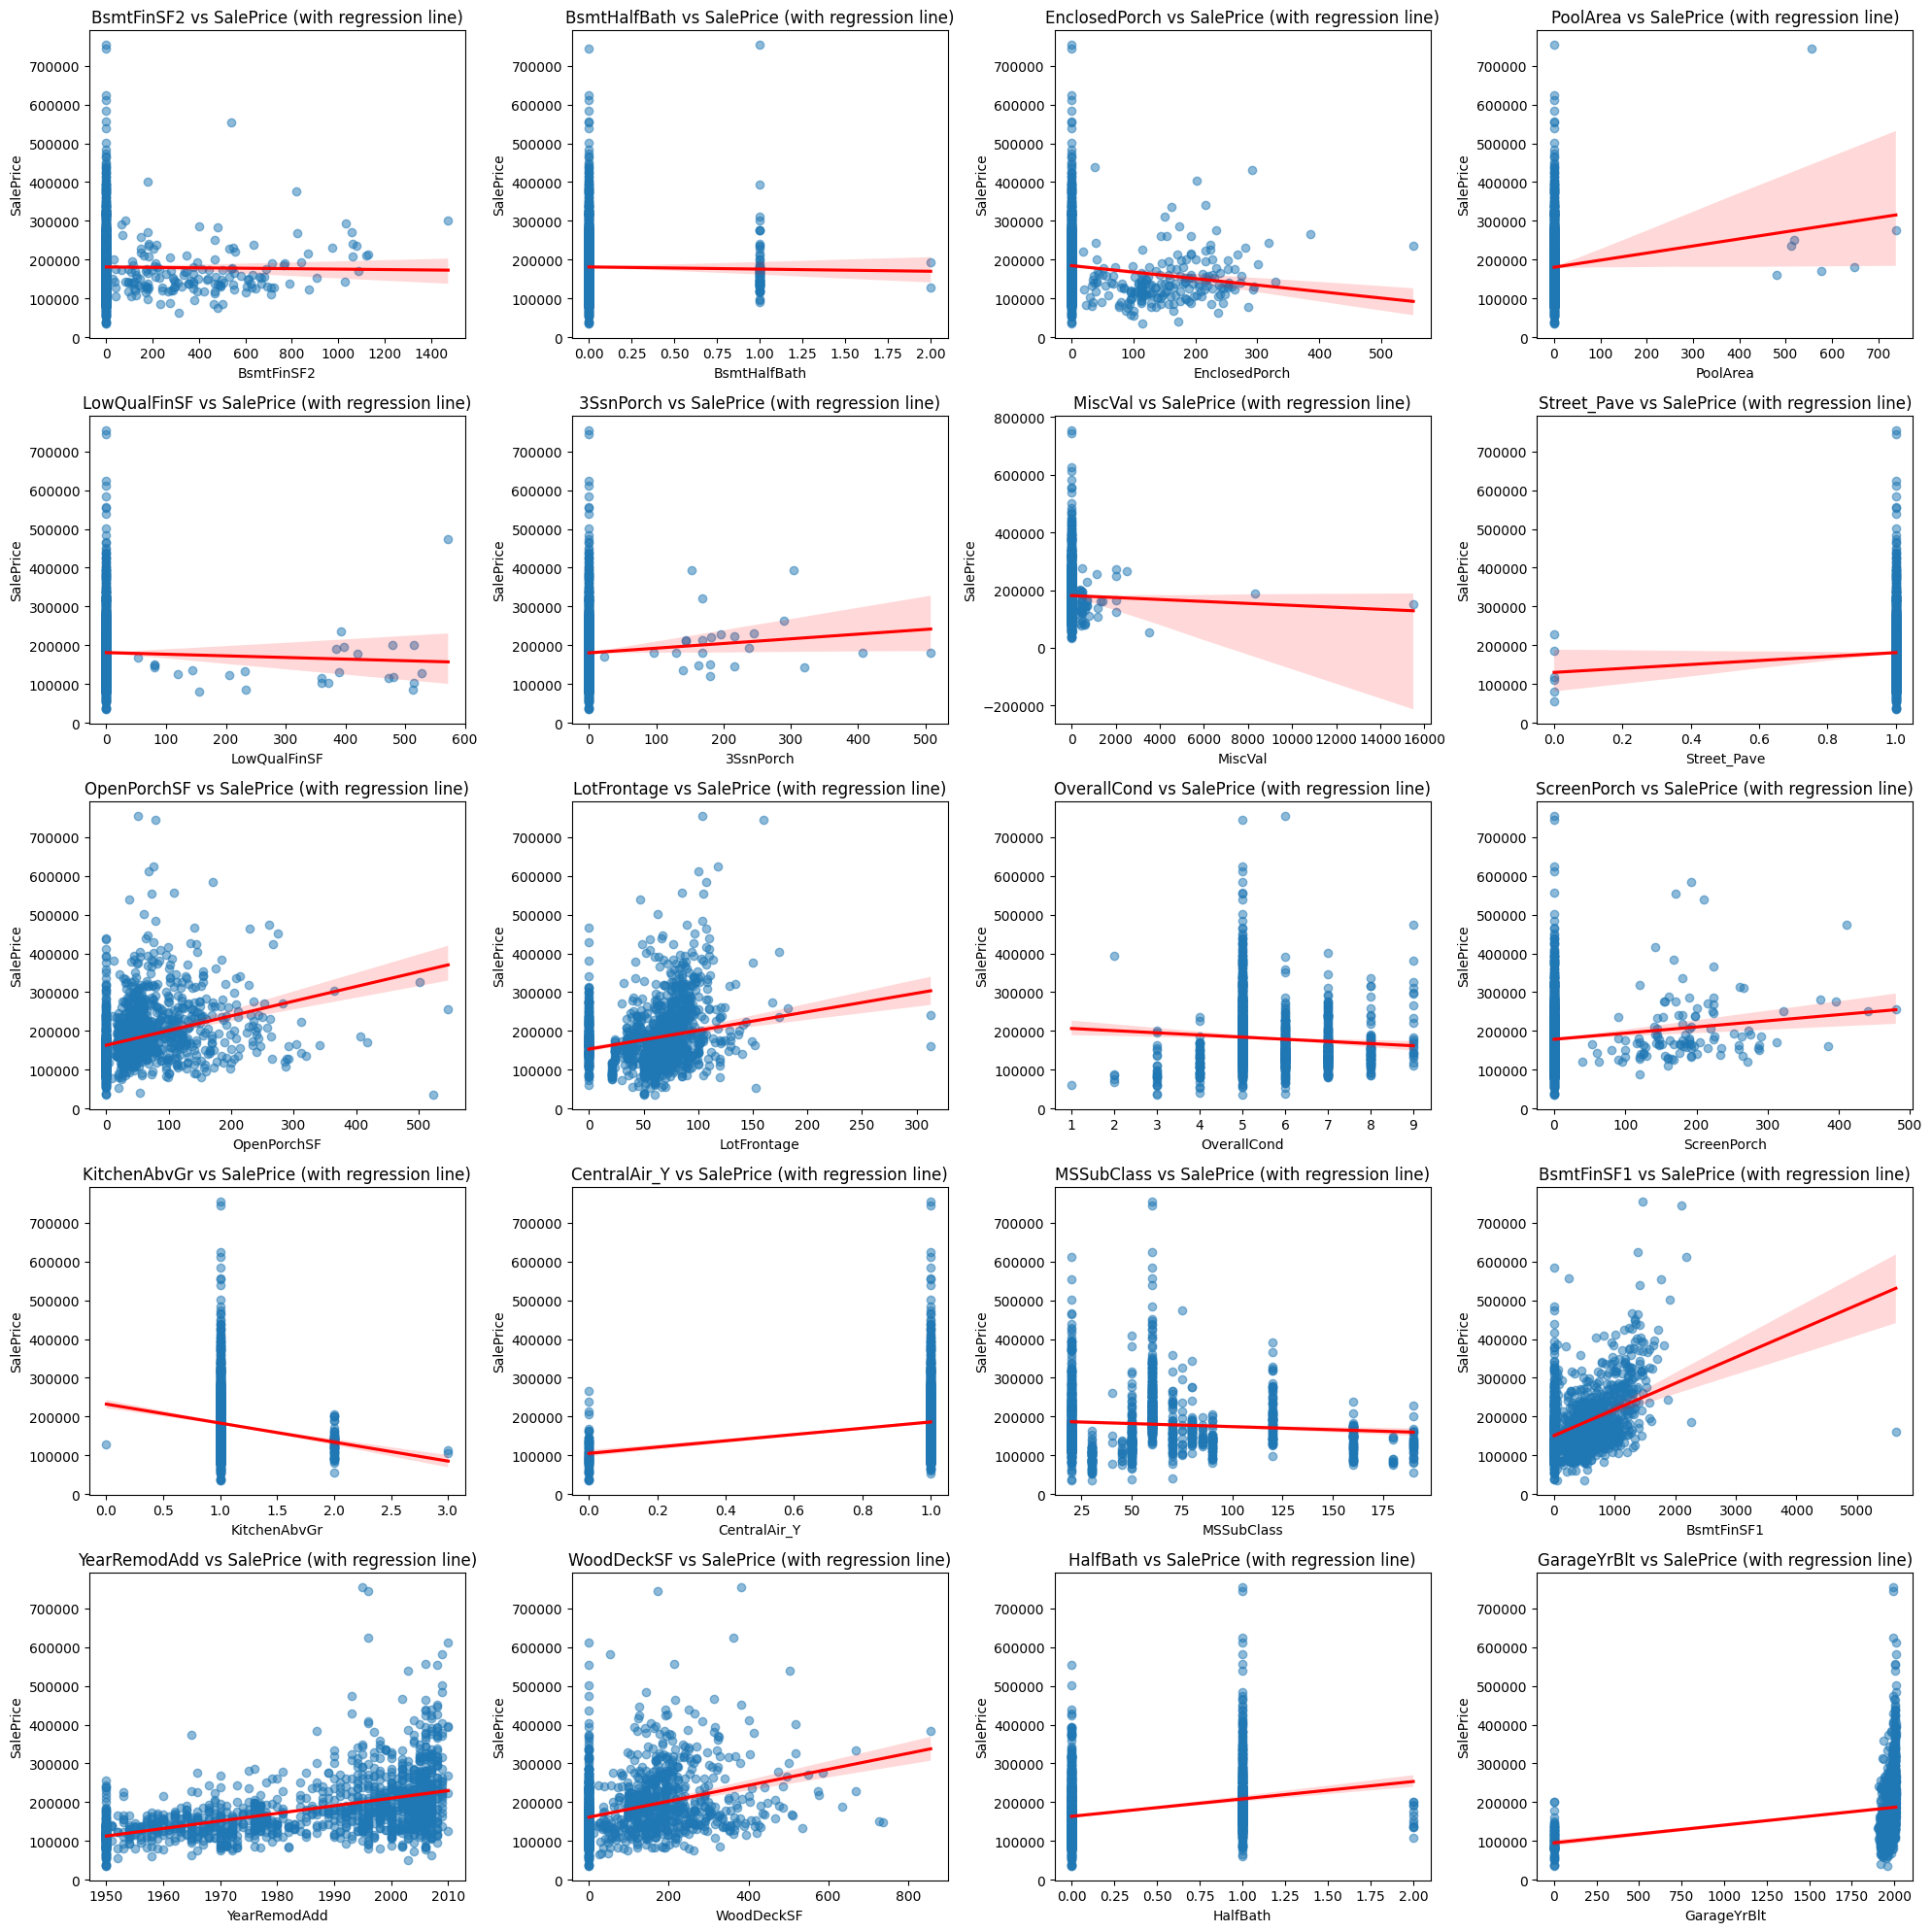

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

variables = ['BsmtFinSF2',
 'BsmtHalfBath',
 'EnclosedPorch',
 'PoolArea',
 'LowQualFinSF',
 '3SsnPorch',
 'MiscVal',
 'Street_Pave',
 'OpenPorchSF',
 'LotFrontage',
 'OverallCond',
 'ScreenPorch',
 'KitchenAbvGr',
 'CentralAir_Y',
 'MSSubClass',
 'BsmtFinSF1',
 'YearRemodAdd',
 'WoodDeckSF',
 'HalfBath',
 'GarageYrBlt']

n_cols = 4
n_rows = -(-len(variables) // n_cols)
plt.figure(figsize=(20, 4 * n_rows))

for idx, var in enumerate(variables):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.regplot(data=clean_df, x=var, y='SalePrice', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.xlabel(var)
    plt.ylabel('SalePrice')
    plt.title(f'{var} vs SalePrice (with regression line)')

plt.tight_layout()
plt.show()

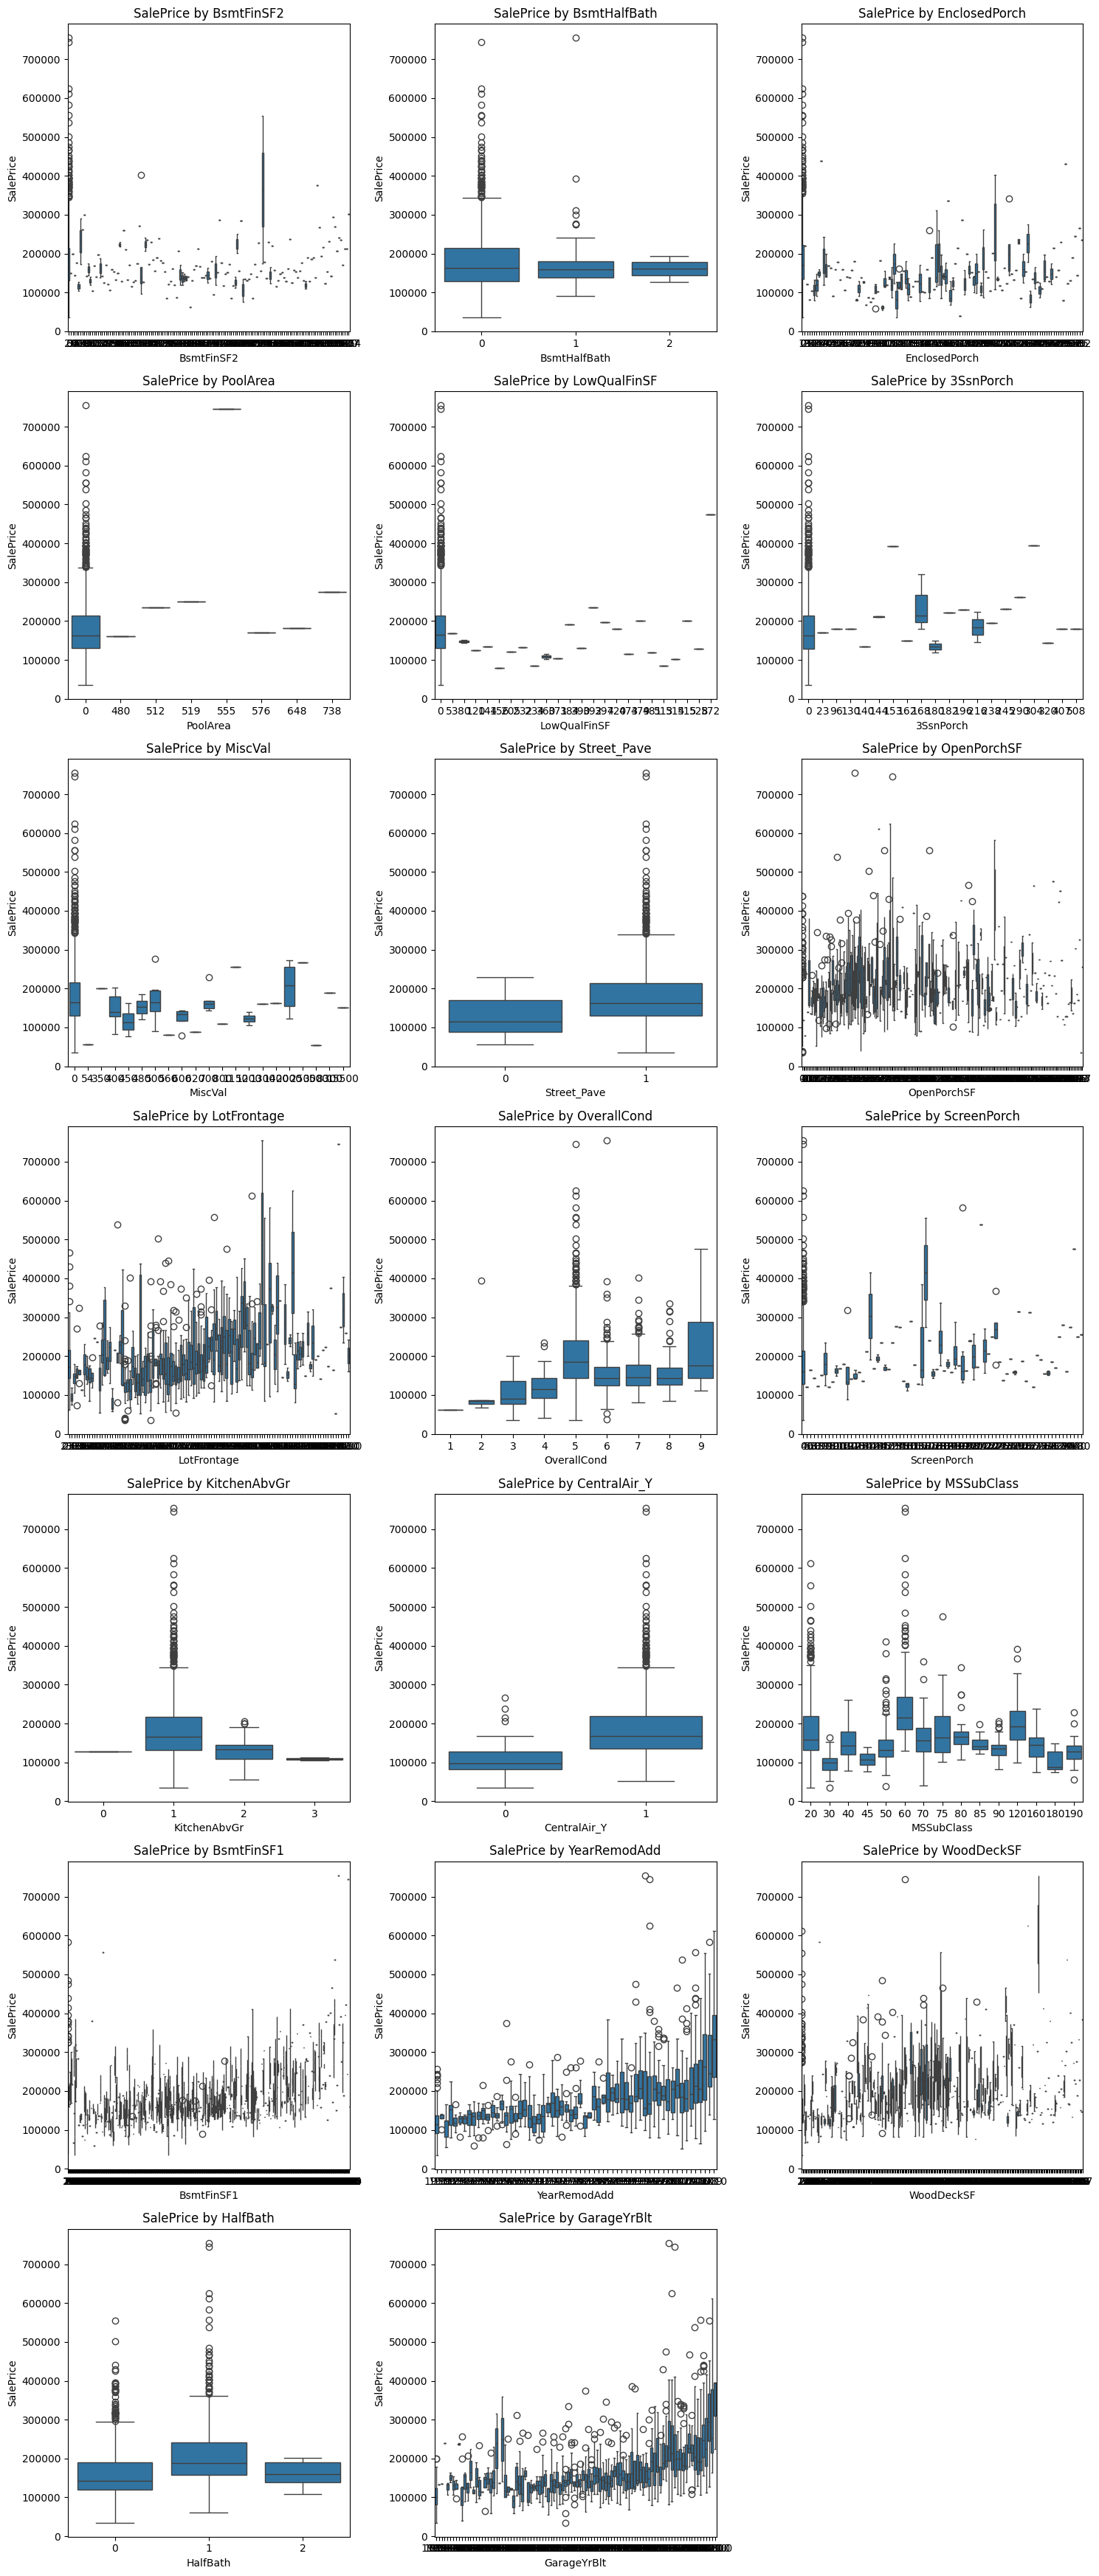

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

boxplot_vars = ['BsmtFinSF2',
 'BsmtHalfBath',
 'EnclosedPorch',
 'PoolArea',
 'LowQualFinSF',
 '3SsnPorch',
 'MiscVal',
 'Street_Pave',
 'OpenPorchSF',
 'LotFrontage',
 'OverallCond',
 'ScreenPorch',
 'KitchenAbvGr',
 'CentralAir_Y',
 'MSSubClass',
 'BsmtFinSF1',
 'YearRemodAdd',
 'WoodDeckSF',
 'HalfBath',
 'GarageYrBlt']

n_cols = 3
n_rows = -(-len(boxplot_vars) // n_cols)
plt.figure(figsize=(5 * n_cols, 5 * n_rows))

for idx, var in enumerate(boxplot_vars):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.boxplot(data=clean_df, x=var, y='SalePrice')
    plt.title(f'SalePrice by {var}')
    plt.xlabel(var)
    plt.ylabel('SalePrice')

plt.tight_layout()
plt.show()


In [ ]:
clean_df

,Street_Pave,CentralAir_Y,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,1,60,65.0,8450,7,5,2003,2003,196.0,...,0,61,0,0,0,0,0,2,2008,208500
1,1,1,20,80.0,9600,6,8,1976,1976,0.0,...,298,0,0,0,0,0,0,5,2007,181500
2,1,1,60,68.0,11250,7,5,2001,2002,162.0,...,0,42,0,0,0,0,0,9,2008,223500
3,1,1,70,60.0,9550,7,5,1915,1970,0.0,...,0,35,272,0,0,0,0,2,2006,140000
4,1,1,60,84.0,14260,8,5,2000,2000,350.0,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1,1,60,62.0,7917,6,5,1999,2000,0.0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1,1,20,85.0,13175,6,6,1978,1988,119.0,...,349,0,0,0,0,0,0,2,2010,210000
1457,1,1,70,66.0,9042,7,9,1941,2006,0.0,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1,1,20,68.0,9717,5,6,1950,1996,0.0,...,366,0,112,0,0,0,0,4,2010,142125


## Question of interest
1. What are the most important factors that affect housing price?
2. How well can machine learning models predict housing price and which models behaves the best?

## Methods
One hot encoding: to covert variable values, \
Graphing: to visualize dataset and correlation using scatter plot, heatmap, etc., \
RMSE: evaluation metric,\
Ensemble Learning: to combine weak models such as linear regression, decision trees, etc.,\
Dimension Reduction methods: PCA, DBSCAN, Mutual Information.


For variables with missing values, we will do feature engineering to look at the structure of the data and decide how to deal with them.

Dropping Variables
We are choosing to remove some of the variables
- Month, Year Sold
- Size of Car
- PoolArea and replace if Pool
- Alley
- MSZoning

In [ ]:
corrmat=numeric_df.corr()
y = numeric_df['SalePrice']
topCorrelation = corrmat['SalePrice'].sort_values(ascending=False).head(21)
topCorrelation = topCorrelation.drop('SalePrice')
print(list(set(topCorrelation.index) - )


['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath', 'LotArea']


## Summary Statistics

In [ ]:
  import pandas as pd

# Load your dataset (in this case, a CSV file)
file_path = '/train.csv'  # Update the file path to your actual file location
try:
    # Load the CSV file
    df = pd.read_csv(file_path)

    # Print the first few rows of the data to get a quick look
    print("First 5 rows of the dataset:")
    print(df.head())

    # Print the structure of the dataset
    print("\nDataset Info (structure):")
    df.info()

    # Summary statistics for numerical columns
    print("\nSummary statistics for numerical columns:")
    print(df.describe())

    # Print the column names to understand the dataset's features
    print("\nColumn names in the dataset:")
    print(df.columns)

    # Checking for missing values
    print("\nMissing values in the dataset:")
    print(df.isnull().sum())

except Exception as e:
    print(f"Error loading the dataset: {e}")